In [6]:
import numpy as np
import pandas as pd
import time
import sklearn


readdata = pd.read_csv("C:/Users/Dom/MPhys/TheGrandTour/wine_data.txt", sep="\t", header=None);
data = np.array(readdata);
data = np.delete(data, 0, 0)
data = data.astype(float)
data = np.swapaxes(data,0,1)


# Need to seperate the classification dimension:
classification = data[13]
data = np.delete(data, 13, axis=0)


# make list of colours for each number:
data_colour = []
for i in range(len(classification)):
    if classification[i] == 1:
        data_colour.append("r")
    elif classification[i] == 2:
        data_colour.append("b")
    elif classification[i] == 3:
        data_colour.append("g")
        
# Normalizes the data        
for i in range(0, np.shape(data)[1]):
    data[:,i] = (data[:,i] / np.ndarray.max(data[:,i])) * 2 - 1
    
        


#VARIABLES
stepSize = 0.01
nSteps = 1000

def getAlpha(d):
    """
    NEEDS IMPLEMENTATION
    Should produce 1xd(d-1)/2 array of position in grand tour.
    """
    p = d*(d-1)/2     
    primeList = []
    count = 1
    while len(primeList) < p:
        count += 1
        primeBool = False
        for i in range(2, count - 1):
            if count % i == 0:
                primeBool = True
        if primeBool == False:
            irrational = (np.sqrt(count)%1)
            primeList.append(irrational)
            
    primeList = np.asarray(primeList)
    primeList = primeList.dot(stepSize)
    """
    Irrational number generation using exponentials, not being used
    p = int(d*(d-1)/2)
    alpha = np.zeros(p) #alpha(t) parameters defining grand tour in G2,d
    for i in range(0,p):
        alpha[i] = (np.exp(i) % 1) * 2 * np.pi
        
    alpha = alpha.dot(0.001)
    """
    
    return primeList


def getAngles(alpha,d):
    """""
    Inputs: 
    alpha = 1xd(d-1)/2 array defining position on grand tour
    d = dimensions of data
    Outputs a dxd array of angles required for the transformation
    """
    theta = np.zeros((d,d));
    i = 0;
    k = 0;
    
    while i < d-1:
        j = i + 1;
        
        while j < d:
            theta[i][j] = alpha[k];
            j += 1;
            k += 1;
    
        i+= 1;
        
    return theta;


def RotationMatrix(i, j, d, theta):
    """
    Inputs:
    i = first indicie of rotating plane
    j = second indicie of rotating plane
    d = dimensions of data
    theta = dxd array of angle of rotation of rotating plane
    Outputs a rotating matrix to rotate plane of ixj plane by theta_ij
    """
    R = np.identity(d)
    R[i,i] = np.cos(theta)
    R[i,j] = -1*np.sin(theta)
    R[j,i] = np.sin(theta)
    R[j,j] = np.cos(theta)
    return R


def BetaFn(d, theta):
    """
    Inputs:
    d = dimensions of data
    theta = dxd array of angle of rotation ixj plane
    Outputs the full matrix transformation for all rotations
    """
    b = RotationMatrix(1, 2, d, theta[1,2])
    i = 1
    j = 2
    for i in range(d):
        for j in range(d):
            if j <= i:
                continue
            if i==1 and j==2:
                continue
            b = np.matmul(b, RotationMatrix(i, j, d, theta[i,j]))
            
    return b


def GrandTour(data, nSteps):
    """
    Inputs:
    data = array of data points, dimensions x npoints
    Outputs a 3D array number of points x t x dimensions, where t
    the time step at that point in the tour
    """

    d = np.shape(data)[0] #dimensions of data
    nPoints = np.shape(data)[1] #number of data points
    tData = np.zeros((nSteps,d,nPoints)) #initialise 3d matrix to store stransforemd data at each timestep
    tBeta = np.zeros((nSteps,d,d))
    Alpha = getAlpha(d)

    
    for t in range(0, nSteps):
        
        
        alpha = Alpha.dot(t)
        theta = getAngles(alpha, d)
        b = BetaFn(d, theta)
        a = np.matmul(b, data)
        tData[t,:,:] = a
        tBeta[t,:,:] = b
        
    return tData


tData = GrandTour(data, nSteps)



In [5]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

%matplotlib inline

AttributeError: module 'matplotlib' has no attribute '_cntr'

In [ ]:
for i in range(0, 1000):
    if i % 2 == 0:
        xData = tData[i][0]
        yData = tData[i][1]

        plt.scatter(xData, yData, color = data_colour)
        plt.show()

        
#slider_depth.on_changed(update_depth)
plt.show()


In [ ]:
testlist = [[1, 2, 3, 4], [1.1, 2.2 ,3.3, 4.4]]

In [ ]:
testlist

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Slider

class ChangingPlot(object):
    def __init__(self):
        self.inc = 0.5

        self.fig, self.ax = plt.subplots()
        self.sliderax = self.fig.add_axes([0.2, 0.02, 0.6, 0.03],
                                          axisbg='yellow')

        self.slider = Slider(self.sliderax, 'Value', 0, 10, valinit=self.inc)
        self.slider.on_changed(self.update)
        self.slider.drawon = False

        x = np.arange(0, 10.5, self.inc)
        self.ax.plot(x, x, 'ro')
        self.dot, = self.ax.plot(self.inc, self.inc, 'bo', markersize=18)

    def update(self, value):
        value = int(value / self.inc) * self.inc
        self.dot.set_data([[value],[value]])
        self.slider.valtext.set_text('{}'.format(value))
        self.fig.canvas.draw()

    def show(self):
        plt.show()

p = ChangingPlot()
p.show()


<IPython.core.display.Javascript object>


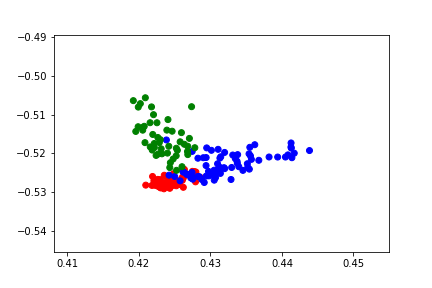

interactive(children=(FloatSlider(value=1.0, description='timestep', max=1000.0, step=1.0), Output()), _dom_cl…

<function __main__.plot_func>

In [49]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt


%matplotlib inline
%matplotlib notebook

import numpy as np

fig = plt.figure()
def plot_func(timestep):
    fig.clear()
    xData = tData[int(timestep)][3]
    yData = tData[int(timestep)][5]
    plt.scatter(xData, yData, color = data_colour)
    plt.show()

interact(plot_func, timestep = widgets.FloatSlider(value=1,
                                               min=0,
                                               max=1000,
                                               step=1))





<IPython.core.display.Javascript object>


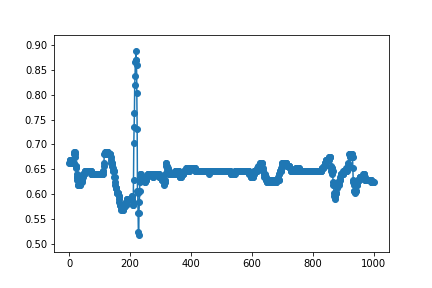

In [38]:
from sklearn.svm import SVC,LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt


accuracy = []

for i in range(1000):
    xData = tData[i][3]
    yData = tData[i][5]
    nData = np.vstack((xData, yData)).T
    
    clf = OneVsRestClassifier(SVC(kernel='linear'), n_jobs=-1)
    clf.fit(nData, classification)

    score = clf.score(nData, classification)
    accuracy.append(score)


x = list(range(0, len(accuracy)))

fig.clear()
new = plt.figure()
plt.scatter(x, accuracy)
plt.plot(x, accuracy, "-")


<IPython.core.display.Javascript object>


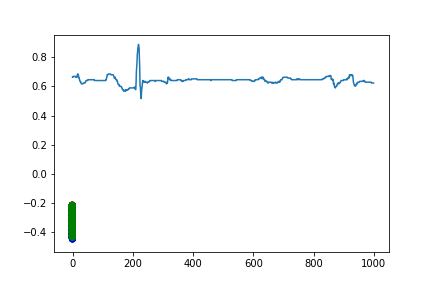

219

In [48]:
fig.clear()
new = plt.figure()
plt.plot(x, accuracy, "-", marker="None")

max_accuracy = max(accuracy)
max_accuracy = [i for i, j in enumerate(accuracy) if j == max_accuracy]
max_accuracy = max_accuracy[0]
max_accuracy

In [31]:
len(accuracy)

1000

In [17]:
svm.SVC?


<IPython.core.display.Javascript object>


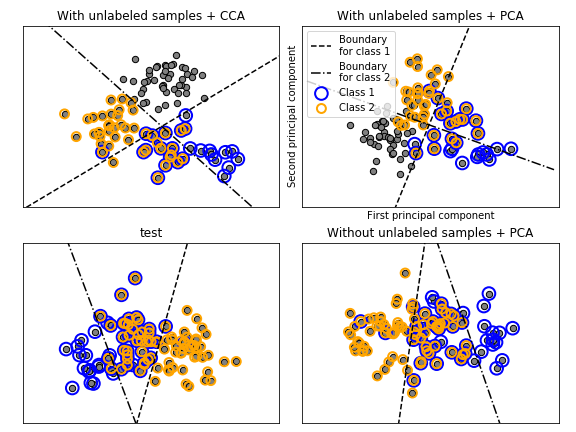

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA


def plot_hyperplane(clf, min_x, max_x, linestyle, label):
    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(min_x - 5, max_x + 5)  # make sure the line is long enough
    yy = a * xx - (clf.intercept_[0]) / w[1]
    plt.plot(xx, yy, linestyle, label=label)


def plot_subfigure(X, Y, subplot, title, transform):
    if transform == "pca":
        X = PCA(n_components=2).fit_transform(X)
    elif transform == "cca":
        X = CCA(n_components=2).fit(X, Y).transform(X)
    else:
        raise ValueError

    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])

    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])

    classif = OneVsRestClassifier(SVC(kernel='linear'))
    classif.fit(X, Y)

    plt.subplot(2, 2, subplot)
    plt.title(title)

    zero_class = np.where(Y[:, 0])
    one_class = np.where(Y[:, 1])
    plt.scatter(X[:, 0], X[:, 1], s=40, c='gray', edgecolors=(0, 0, 0))
    plt.scatter(X[zero_class, 0], X[zero_class, 1], s=160, edgecolors='b',
                facecolors='none', linewidths=2, label='Class 1')
    plt.scatter(X[one_class, 0], X[one_class, 1], s=80, edgecolors='orange',
                facecolors='none', linewidths=2, label='Class 2')

    plot_hyperplane(classif.estimators_[0], min_x, max_x, 'k--',
                    'Boundary\nfor class 1')
    plot_hyperplane(classif.estimators_[1], min_x, max_x, 'k-.',
                    'Boundary\nfor class 2')
    plt.xticks(())
    plt.yticks(())

    plt.xlim(min_x - .5 * max_x, max_x + .5 * max_x)
    plt.ylim(min_y - .5 * max_y, max_y + .5 * max_y)
    if subplot == 2:
        plt.xlabel('First principal component')
        plt.ylabel('Second principal component')
        plt.legend(loc="upper left")


plt.figure(figsize=(8, 6))

X, Y = make_multilabel_classification(n_classes=2, n_labels=1,
                                      allow_unlabeled=True,
                                      random_state=1)

plot_subfigure(X, Y, 1, "With unlabeled samples + CCA", "cca")
plot_subfigure(X, Y, 2, "With unlabeled samples + PCA", "pca")

X, Y = make_multilabel_classification(n_classes=2, n_labels=1,
                                      allow_unlabeled=False,
                                      random_state=1)

plot_subfigure(X, Y, 3, "Without unlabeled samples + CCA", "cca")
plot_subfigure(X, Y, 4, "Without unlabeled samples + PCA", "pca")

plt.subplots_adjust(.04, .02, .97, .94, .09, .2)
plt.show()